## Import Modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/bigpro12313/face'

/content/drive/MyDrive/bigpro12313/face


In [ ]:
!unzip -qq '/content/drive/MyDrive/bigpro12313/face/archive.zip'

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
#from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import Model, load_model, save_model
from PIL import Image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

## Load the Dataset

In [ ]:
BASE_DIR = '/content/drive/MyDrive/bigpro12313/face/UTKFace'
a =os.listdir(BASE_DIR)

In [ ]:
len(a)

23708

In [ ]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []

for filename in tqdm(a):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    image_paths.append(image_path)
    age_labels.append(age)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age']= image_paths, age_labels
df

,image,age
0,/content/drive/MyDrive/bigpro12313/face/UTKFac...,85
1,/content/drive/MyDrive/bigpro12313/face/UTKFac...,84
2,/content/drive/MyDrive/bigpro12313/face/UTKFac...,8
3,/content/drive/MyDrive/bigpro12313/face/UTKFac...,78
4,/content/drive/MyDrive/bigpro12313/face/UTKFac...,80
...,...,...
23703,/content/drive/MyDrive/bigpro12313/face/UTKFac...,14
23704,/content/drive/MyDrive/bigpro12313/face/UTKFac...,15
23705,/content/drive/MyDrive/bigpro12313/face/UTKFac...,14
23706,/content/drive/MyDrive/bigpro12313/face/UTKFac...,16


In [ ]:
#df['age'].loc[df['age']<10]=0
df['age'].loc[(df['age']>=0) & (df['age']<20)] = 0
df['age'].loc[(df['age']>=20) & (df['age']<30)] = 1
df['age'].loc[(df['age']>=30) & (df['age']<40)] = 2
df['age'].loc[(df['age']>=40) & (df['age']<50)] = 3
df['age'].loc[(df['age']>=50) & (df['age']<60)] = 4
df['age'].loc[(df['age']>=60)]= 5

In [ ]:
df

,image,age
0,/content/drive/MyDrive/bigpro12313/face/UTKFac...,5
1,/content/drive/MyDrive/bigpro12313/face/UTKFac...,5
2,/content/drive/MyDrive/bigpro12313/face/UTKFac...,0
3,/content/drive/MyDrive/bigpro12313/face/UTKFac...,5
4,/content/drive/MyDrive/bigpro12313/face/UTKFac...,5
...,...,...
23703,/content/drive/MyDrive/bigpro12313/face/UTKFac...,0
23704,/content/drive/MyDrive/bigpro12313/face/UTKFac...,0
23705,/content/drive/MyDrive/bigpro12313/face/UTKFac...,0
23706,/content/drive/MyDrive/bigpro12313/face/UTKFac...,0


## Exploratory Data Analysis

In [ ]:
df['image'][0]

'/content/drive/MyDrive/bigpro12313/face/UTKFace/85_1_0_20170110182358244.jpg.chip.jpg'

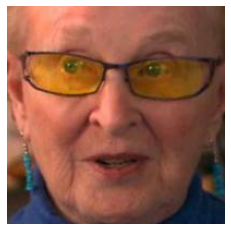

In [ ]:
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

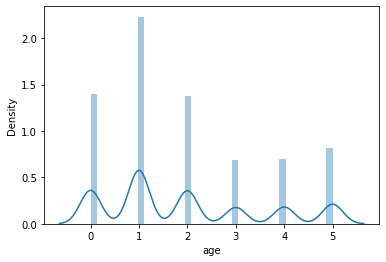

In [ ]:
sns.distplot(df['age'])

In [ ]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = tf.keras.utils.load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age}")
    plt.axis('off')

## Feature Extraction

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = tf.keras.utils.load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [ ]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
X.shape

(23708, 128, 128, 1)

In [ ]:
# normalize the images
X = X/255.0

In [ ]:
len_y = df['age'].nunique()

In [ ]:
y_age = np.array(df['age']) 

In [ ]:
y_age = y_age.astype('int32')

In [ ]:
y_age = to_categorical(y_age, len_y)

In [ ]:
y_age.shape

(23708, 6)

In [ ]:
input_shape = (128, 128, 1)

## Model Creation

In [ ]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_2 = Dense(256, activation='relu') (flatten)

dropout_2 = Dropout(0.3) (dense_2)

output_2 = Dense(6, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_2])

model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])

model.summary()

In [ ]:
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=5,
                   verbose=1,
                   restore_best_weights=True)

In [ ]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
# train model
history = model.fit(x=X, y=y_age, batch_size=32, epochs=100, validation_split=0.2, callbacks=[es])

Epoch 1/100
593/593 [==============================] - 13s 21ms/step - loss: 1.9057 - accuracy: 0.2750 - val_loss: 2.4395 - val_accuracy: 0.4336
Epoch 2/100
593/593 [==============================] - 12s 20ms/step - loss: 1.6888 - accuracy: 0.2885 - val_loss: 1.7639 - val_accuracy: 0.4040
Epoch 3/100
593/593 [==============================] - 12s 20ms/step - loss: 1.6335 - accuracy: 0.3342 - val_loss: 1.7505 - val_accuracy: 0.4327
Epoch 4/100
593/593 [==============================] - 12s 20ms/step - loss: 1.6106 - accuracy: 0.3253 - val_loss: 2.6497 - val_accuracy: 0.5597
Epoch 5/100
593/593 [==============================] - 12s 20ms/step - loss: 1.5717 - accuracy: 0.3648 - val_loss: 1.4973 - val_accuracy: 0.6364
Epoch 6/100
593/593 [==============================] - 12s 20ms/step - loss: 1.4981 - accuracy: 0.4060 - val_loss: 2.5794 - val_accuracy: 0.5926
Epoch 7/100
593/593 [==============================] - 12s 20ms/step - loss: 1.4965 - accuracy: 0.4074 - val_loss: 1.4808 - val_ac

In [ ]:
model.save('/content/drive/MyDrive/bigpro12313/face/face_10s2.h5')

## Plot the Results

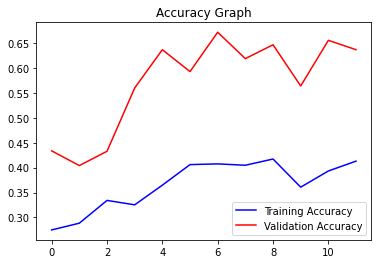

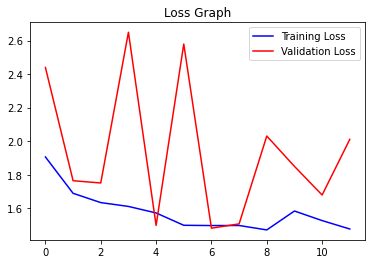

In [ ]:
# plot results for gender
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

# Prediction with Test Data

In [ ]:
image_index = 100
print("Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_age = round(pred[0][0][0])
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

In [ ]:
image_index = 0
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))

1/1 [==============================] - 0s 69ms/step


In [ ]:
pred_array = np.zeros(shape=(pred.shape[0], pred.shape[1]))
idx = 0

for arr_val in pred :
    # print(arr_val)
    pred_array[idx][arr_val.argmax()] = 1
    idx += 1

In [ ]:
pred_array.shape

(1, 6)

In [ ]:
character = {0:'10대', 1:'20대', 2:'30대', 3:'40대', 4:'50대', 5:'60대 이상'}

{'60대 이상'}


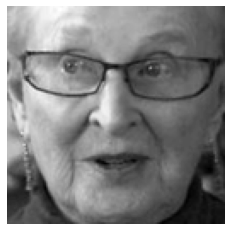

In [ ]:
print({character[pred_array[0].argmax()]})
plt.axis('off')
plt.imshow(X[0].reshape(128, 128), cmap='gray')

1/1 [==============================] - 0s 18ms/step
{'60대 이상'}


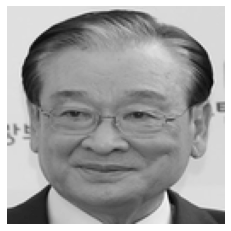

In [ ]:
features = []
img = tf.keras.utils.load_img('/content/drive/MyDrive/bigpro12313/face/test10.PNG', grayscale=True)
img = img.resize((128, 128), Image.ANTIALIAS)
img = np.array(img)
features.append(img)
features = np.array(features)
# ignore this step if using RGB
features = features.reshape(len(features), 128, 128, 1)
features=features/255.0

pred = model.predict(features[0].reshape(1, 128, 128, 1))
pred_array = np.zeros(shape=(pred.shape[0], pred.shape[1]))
pred_array[0][pred.argmax()] = 1



print({character[pred_array[0].argmax()]})
plt.axis('off')
plt.imshow(features[0].reshape(128, 128), cmap='gray')